# Filtering out redundant strings

| Author              | Description                                         |
|---------------------|-----------------------------------------------------|
| Anh Tu Duong Nguyen | Filter out redundant strings to reduce the size of the dataset |

In [7]:
import pandas as pd
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import dask.dataframe as dd
import dask

In [8]:
csv_path = '../data/reviews.csv'

In [10]:
df = pd.read_csv(csv_path)
df

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31
...,...,...,...,...,...,...,...,...,...,...
9073123,104824,CTJman,2014-06-08,,NaN,NaN,NaN,NaN,NaN,4.00
9073124,104824,IMSPEAKNOENGLISH,2014-06-06,,NaN,NaN,NaN,NaN,NaN,5.00
9073125,104824,twizzard,2014-06-05,,NaN,NaN,NaN,NaN,NaN,5.00
9073126,104824,bootdown21,2014-06-04,,NaN,NaN,NaN,NaN,NaN,4.50


In [11]:
df_unique = df[df['text'].map(df['text'].value_counts()) == 1]
df_unique.shape

(2893954, 10)

In [12]:
average_word_count = df_unique['text'].apply(lambda x: len(str(x).split())).mean()

print(f"Average number of words per sentence: {average_word_count}")

Average number of words per sentence: 114.14884410740461


In [13]:
df_unique = df_unique[df_unique['text'].apply(lambda x: len(str(x).split())) >= average_word_count]
df_unique.shape

(1149509, 10)

In [14]:
import pandas as pd

# Define expanded keyword lists for each ABSA-relevant aspect
aspect_keywords = {
    'look': [
        'look', 'appearance', 'color', 'colour', 'head', 'foam', 'lacing', 'clarity',
        'hazy', 'opaque', 'transparent', 'visual', 'bubble', 'carbonation', 'layer'
    ],
    'smell': [
        'smell', 'aroma', 'nose', 'scent', 'fragrance', 'odor', 'bouquet',
        'sniff', 'whiff', 'malty aroma', 'hoppy aroma'
    ],
    'taste': [
        'taste', 'flavor', 'flavour', 'aftertaste', 'bitterness', 'sweetness',
        'sourness', 'dry', 'bitter', 'sweet', 'sour', 'savory', 'malty', 'hoppy',
        'balanced', 'burnt', 'roasty', 'yeasty', 'complex'
    ],
    'feel': [
        'feel', 'mouthfeel', 'texture', 'body', 'weight', 'creaminess',
        'smoothness', 'carbonation', 'coating', 'slick', 'watery', 'full-bodied',
        'astringent', 'dryness', 'crisp', 'tingle'
    ]
}

# Convert all text to lowercase for consistent matching
df_unique['text'] = df_unique['text'].astype(str).str.lower()

# Create a boolean mask identifying whether each text contains at least one aspect keyword
aspect_mask = df_unique['text'].apply(
    lambda text: any(
        any(keyword in text for keyword in keywords)
        for keywords in aspect_keywords.values()
    )
)

# Filter the DataFrame to retain only rows that mention at least one aspect
df_filtered = df_unique[aspect_mask].copy()

# Create a new column that lists all aspects mentioned in each review
df_filtered['mentioned_aspects'] = df_filtered['text'].apply(
    lambda text: [
        aspect for aspect, keywords in aspect_keywords.items()
        if any(keyword in text for keyword in keywords)
    ]
)

# Save the filtered and annotated dataset to CSV
df_filtered.to_csv('reviews_with_aspects_filtered.csv', index=False)
print(f"Saved {len(df_filtered)} reviews with aspect mentions to 'reviews_with_aspects_filtered.csv'")


Saved 1148685 reviews with aspect mentions to 'reviews_with_aspects_filtered.csv'


In [15]:
# Define the aspect-specific keyword lists
aspect_keywords = {
    'look': [
        'look', 'appearance', 'color', 'colour', 'head', 'foam', 'lacing', 'clarity',
        'hazy', 'opaque', 'transparent', 'visual', 'bubble', 'carbonation', 'layer'
    ],
    'smell': [
        'smell', 'aroma', 'nose', 'scent', 'fragrance', 'odor', 'bouquet',
        'sniff', 'whiff', 'malty aroma', 'hoppy aroma'
    ],
    'taste': [
        'taste', 'flavor', 'flavour', 'aftertaste', 'bitterness', 'sweetness',
        'sourness', 'dry', 'bitter', 'sweet', 'sour', 'savory', 'malty', 'hoppy',
        'balanced', 'burnt', 'roasty', 'yeasty', 'complex'
    ],
    'feel': [
        'feel', 'mouthfeel', 'texture', 'body', 'weight', 'creaminess',
        'smoothness', 'carbonation', 'coating', 'slick', 'watery', 'full-bodied',
        'astringent', 'dryness', 'crisp', 'tingle'
    ]
}

# Convert text column to lowercase for consistent keyword matching
df_unique['text'] = df_unique['text'].astype(str).str.lower()

# Create a boolean column for each aspect to indicate if its keywords are mentioned
for aspect, keywords in aspect_keywords.items():
    df_unique[f'has_{aspect}'] = df_unique['text'].apply(
        lambda text: any(keyword in text for keyword in keywords)
    )

# Filter to retain only rows where all four aspects are present
df_all_aspects = df_unique[
    df_unique['has_look'] &
    df_unique['has_smell'] &
    df_unique['has_taste'] &
    df_unique['has_feel']
].copy()

# Optional: add a column explicitly stating the presence of all aspects
df_all_aspects['mentioned_aspects'] = ['look, smell, taste, feel'] * len(df_all_aspects)

# Save the result to a new CSV file
df_all_aspects.to_csv('df_unique_with_all_aspects.csv', index=False)
print(f"Filtered {len(df_all_aspects)} rows that contain all four aspects.")


Filtered 914799 rows that contain all four aspects.


In [17]:
df_all_aspects

,beer_id,username,date,text,look,smell,taste,feel,overall,score,has_look,has_smell,has_taste,has_feel,mentioned_aspects
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.0,4.25,4.00,4.03,True,True,True,True,"look, smell, taste, feel"
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. funny story: as i finally wal...,4.75,4.75,4.5,4.50,4.50,4.58,True,True,True,True,"look, smell, taste, feel"
59,150672,biboergosum,2014-12-26,"355ml can, the latest from this nascent cra...",3.75,4.25,4.0,3.75,3.75,3.97,True,True,True,True,"look, smell, taste, feel"
69,104824,Fcolle2,2014-05-27,batch 209 pours thick dark viscous black in...,4.25,4.75,4.5,4.75,4.50,4.57,True,True,True,True,"look, smell, taste, feel"
73,104824,kevanb,2014-05-24,12oz bottle poured into a pipeworks snifter...,4.00,4.50,4.5,4.25,4.50,4.45,True,True,True,True,"look, smell, taste, feel"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9073081,58482,NeroFiddled,2009-09-17,"carefully poured to leave the yeast behind,...",4.00,4.50,4.0,4.00,4.00,4.12,True,True,True,True,"look, smell, taste, feel"
9073088,58482,DIM,2009-09-04,a: this was a hazy light copery color with ...,4.00,4.00,3.5,3.00,3.50,3.60,True,True,True,True,"look, smell, taste, feel"
9073091,58482,jdaelhousen,2009-08-28,pour produces a solid contribution of body ...,4.00,5.00,4.5,4.00,4.00,4.44,True,True,True,True,"look, smell, taste, feel"
9073096,58482,firkinhophead,2009-08-21,"pours a hazy, almost cloudy, autumn gold. a...",3.50,4.00,4.0,3.50,4.00,3.92,True,True,True,True,"look, smell, taste, feel"


In [18]:
# Define rule: score ≥ 4 → positive, score ≤ 2 → negative, else → neutral
def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

# Apply mapping to generate sentiment column
df_all_aspects['sentiment'] = df_all_aspects['score'].apply(score_to_sentiment)


Sentiment distribution before sampling:
 sentiment
neutral     459756
positive    445809
negative      9234
Name: count, dtype: int64


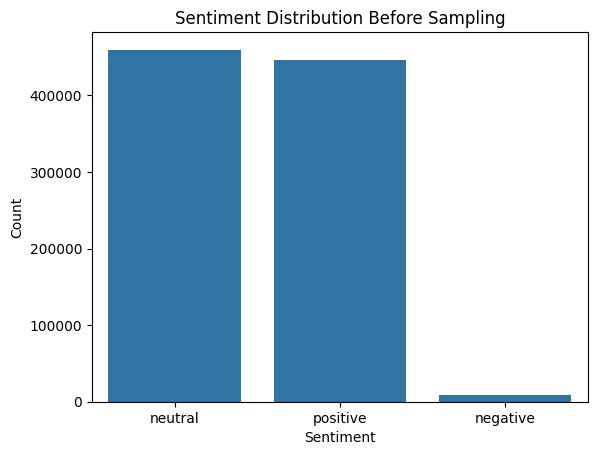

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count distribution
sentiment_counts = df_all_aspects['sentiment'].value_counts()
print("Sentiment distribution before sampling:\n", sentiment_counts)

# Plot
sns.countplot(data=df_all_aspects, x='sentiment', order=sentiment_counts.index)
plt.title('Sentiment Distribution Before Sampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [23]:
# Define desired sample size per sentiment class
n_per_class = 9234

# Perform stratified sampling by sentiment
df_sampled = df_all_aspects.groupby('sentiment').sample(n=n_per_class, random_state=42)

# Reset index
df_sampled.reset_index(drop=True, inplace=True)
print(f"Stratified dataset shape: {df_sampled.shape}")

Stratified dataset shape: (27702, 16)


In [26]:
df_sampled

,beer_id,username,date,text,look,smell,taste,feel,overall,score,has_look,has_smell,has_taste,has_feel,mentioned_aspects,sentiment
0,1428,Aethien,2012-02-12,"poured into a tulip, it looks a nice golden...",3.00,1.5,1.5,2.0,2.0,1.74,True,True,True,True,"look, smell, taste, feel",negative
1,4351,kojevergas,2011-07-31,can served into norrebro bryghus stemware i...,2.50,2.0,2.0,1.5,2.0,1.98,True,True,True,True,"look, smell, taste, feel",negative
2,70485,CMUbrew,2012-03-10,reviewed from notes 500ml can poured into a...,3.00,1.0,1.0,1.5,1.0,1.17,True,True,True,True,"look, smell, taste, feel",negative
3,27069,maximum12,2010-05-12,rec'd a bottle of this unbidden in a recent...,2.50,2.0,2.0,2.0,1.0,1.83,True,True,True,True,"look, smell, taste, feel",negative
4,44788,HarleyRider,2010-06-26,heading out on the boat my wife brings home...,3.00,1.0,1.0,3.0,2.0,1.52,True,True,True,True,"look, smell, taste, feel",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27697,90141,BlackBelt5112203,2013-07-26,5 oz pour into a tasting glass on tap at th...,4.25,4.5,4.5,4.0,4.5,4.44,True,True,True,True,"look, smell, taste, feel",positive
27698,2128,woodychandler,2011-08-08,an afternoon of aus beers continued at my a...,4.00,4.0,4.0,4.0,4.0,4.00,True,True,True,True,"look, smell, taste, feel",positive
27699,19216,05Harley,2011-02-25,bottled on: (should be on the bottom right ...,5.00,4.0,4.0,4.0,4.0,4.06,True,True,True,True,"look, smell, taste, feel",positive
27700,41951,brewdlyhooked13,2008-07-19,appearance - pours a dark reddish caramel w...,4.00,4.0,4.0,4.5,5.0,4.25,True,True,True,True,"look, smell, taste, feel",positive


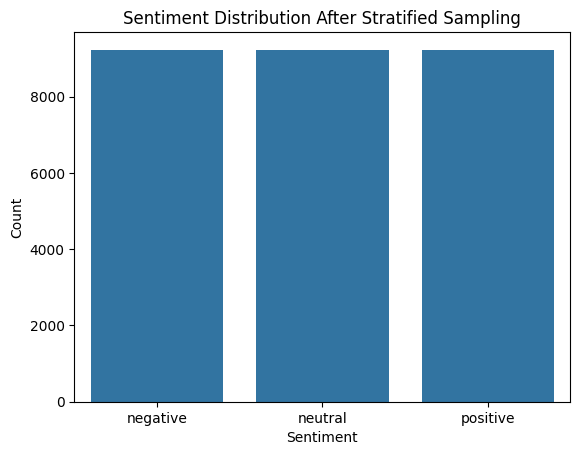

In [24]:
sns.countplot(data=df_sampled, x='sentiment')
plt.title('Sentiment Distribution After Stratified Sampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [25]:
# Save the aspect-filtered dataset (before sampling)
df_all_aspects.to_csv('reviews_with_all_4_aspects.csv', index=False)
print(f"Saved aspect-filtered dataset: {len(df_all_aspects)} rows → 'reviews_with_all_4_aspects.csv'")

# Save the stratified sampled dataset
df_sampled.to_csv('reviews_stratified_sampled.csv', index=False)
print(f"Saved stratified sampled dataset: {len(df_sampled)} rows → 'reviews_stratified_sampled.csv'")


Saved aspect-filtered dataset: 914799 rows → 'reviews_with_all_4_aspects.csv'
Saved stratified sampled dataset: 27702 rows → 'reviews_stratified_sampled.csv'


In [7]:
#df_unique.to_csv("../data/df_unique.csv", index=False)

# Results
* The dataset has been filtered to remove redundant strings.

# Next Steps
Perform the text preprocessing steps needed or described in the outline